In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import stats

In [2]:
f = h5py.File(dir_path+'Lorenz/simulation/simulation.h5','r')
sim = np.array(f['simulation'])
T = np.array(f['MetaData/T'])[0]
discard_t = np.array(f['MetaData/discarded_t'])[0]
dt = np.array(f['MetaData/integration_step'])[0]
f.close()

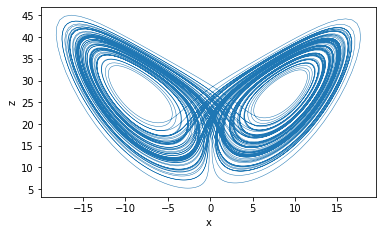

In [3]:
plt.figure(figsize=(6,3.5))
plt.plot(sim[:10000,0],sim[:10000,2],lw=.5)
plt.xlabel('x')
plt.ylabel('z')
# plt.savefig('sample_Lorenz_traj_100s.pdf')
plt.show()

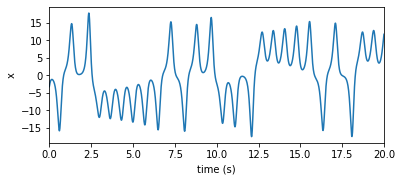

In [4]:
plt.figure(figsize=(6,2.5))
plt.plot(np.arange(0,2000*dt,dt),sim[:2000,0])
plt.xlim(0,20)
plt.yticks(np.arange(-15,16,5))
plt.xlabel('time (s)')
plt.ylabel('x')
# plt.savefig('sample_Lorenz_x_20s.pdf')
plt.show()

In [5]:
f = h5py.File(dir_path+'Lorenz/combined_embedding_results.h5','r')
K_max=20
K_range = np.array(f['K_range'])[:K_max]
seed_range = np.array(f['seed_range'],dtype=int)
length = np.array(f['length'])
prob_K_s = np.array(f['probs'])[:K_max,:]
H_K_s = np.array(f['entropies'])[:K_max,:]
h_K_s = np.array(f['entropy_rates'])[:K_max,:]
Ipred_K_s = np.array(f['Ipreds'])[:K_max,:]
eps_K_s = np.array(f['eps_scale'])[:K_max,:]
f.close()

In [6]:
colors_K = plt.cm.viridis(np.linspace(0,1,len(K_range)))

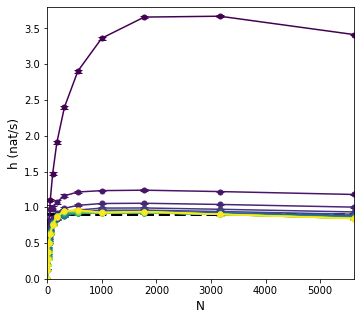

In [7]:
h_Sprott = 0.90563
plt.figure(figsize=(5.5,5))
for k,K in enumerate(K_range):
    mean = np.mean(h_K_s[k,:-1,:].T,axis=0)
    cil = np.percentile(h_K_s[k,:-1,:].T,2.5,axis=0)
    ciu = np.percentile(h_K_s[k,:-1,:].T,97.5,axis=0)
    plt.errorbar(seed_range[:-1],mean,c=colors_K[k],yerr = [mean-cil,ciu-mean],capsize=4,marker='o',ms=5)
plt.xlim(0,seed_range[-2])
plt.ylim(0,3.8)
plt.xlabel('N',fontsize=12)
plt.axhline(h_Sprott,c='k',ls='--',lw=3)
plt.ylabel('h (nat/s)',fontsize=12)
# plt.savefig('h_N_Lorenz_errorbars.pdf')
plt.show()

In [8]:
h_K_s.shape

(20, 16, 249)

In [9]:
hdiff = -np.diff(h_K_s,axis=0)/dt

In [10]:
ks=13
mean,cil,ciu = stats.bootstrap(hdiff[:20,ks,:].T,n_times=1000)

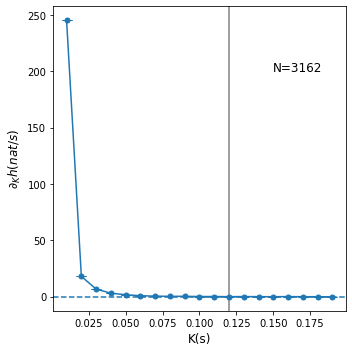

In [11]:
plt.figure(figsize=(5,5))
plt.errorbar(K_range[:19]*dt,mean,[mean-cil,ciu-mean],marker='o',capsize=5,ms=5)
plt.axhline(0,ls='--')
plt.xlabel('K(s)',fontsize=12)
plt.ylabel('$\partial_K h (nat/s)$',fontsize=12)
plt.text(.15,200,'N={}'.format(seed_range[ks]),fontsize=12)
plt.axvline(12*dt,c='gray')
plt.tight_layout()
# plt.savefig('hdiff_Lorenz.pdf')
plt.show()

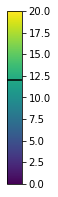

In [12]:
a = np.array([[0,1]])
plt.figure(figsize=(.25, 4))
img = plt.imshow(a, cmap="viridis",vmin=0,vmax=K_range[-1])
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.axhline(12,c='k')
plt.colorbar(cax=cax)
# plt.savefig("colorbar_Krange.pdf")

# Find UPO

In [3]:
n_clusters=3162
f = h5py.File(dir_path+'Lorenz/symbol_seqs/labels_Lorenz_nclusters_{}.h5'.format(n_clusters),'r')
centers_traj = np.array(f['centers_traj'])
labels_traj = np.array(f['labels_traj'],dtype=int)
centers_phspace = np.array(f['centers_phspace'])
labels_phspace = np.array(f['labels_phspace'],dtype=int)
print(list(f.keys()))
f.close()

['centers_phspace', 'centers_sim', 'centers_traj', 'labels_phspace', 'labels_sim', 'labels_traj']


In [4]:
f = h5py.File(dir_path+'Lorenz/embedding/phspace_K_11_m_3.h5','r')
modes = np.array(f['modes'])
phspace = np.array(f['phspace'])
scales = np.array(f['scale'])
f.close()

In [15]:
from scipy.signal import find_peaks


eps = 5e-6
windows = []
wsizes = []
for t_idx in np.random.randint(0,len(phspace)-1000,100000):
    dist = 1/(np.linalg.norm(phspace[t_idx+1:t_idx+500]-phspace[t_idx],axis=1)**2)
    peaks, _ = find_peaks(dist, height=1/(eps**2))
    if len(peaks)>2:
        wsizes.append(peaks)
        windows.append([[t_idx,t_idx+peaks[k]] for k in range(len(peaks))])
        

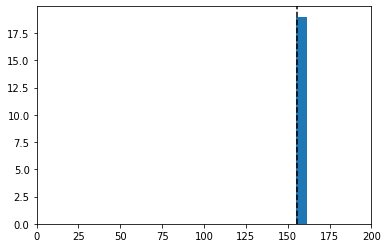

In [16]:
T_UPO_ref = 1.5586522107161747275678702092126960705284
plt.hist(np.hstack(wsizes),bins=50)
plt.xlim(0,200)
plt.axvline(T_UPO_ref/dt,c='k',ls='--')
plt.axvline(T_UPO_ref*2/dt,c='k',ls='--')

plt.show()

In [17]:
t0,tf = np.vstack(windows)[np.argmin(np.hstack(wsizes))]
print((tf-t0)*dt)

1.5499999653548002


In [18]:
T_UPO = (tf-t0)*dt

In [19]:
delay = int(.1/dt)
print(delay)
lcs,P = op_calc.transition_matrix(labels_phspace,delay,return_connected=True)
inv_measure = op_calc.stationary_distribution(P)
final_labels = op_calc.get_connected_labels(labels_phspace,lcs)
n_modes=10
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(eigvals)
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked
phi2 = eigfunctions[:,1]

PF_eigvecs = op_calc.sorted_spectrum(R.T,k=n_modes)[1]
eigfunctions_PF = PF_eigvecs.real/np.linalg.norm(PF_eigvecs.real,axis=0)

10


In [20]:
c_range,rho_sets,idx,kmeans_labels = op_calc.optimal_partition(phi2,inv_measure,P,return_rho=True)

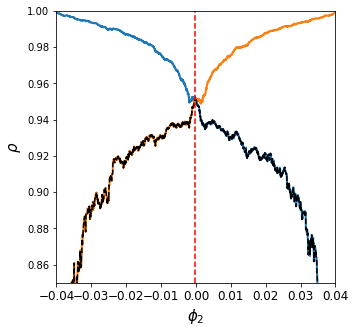

In [21]:
plt.figure(figsize=(5,5))
plt.plot(c_range,rho_sets,lw=2)
rho_c = np.min(rho_sets,axis=1)
plt.plot(c_range,rho_c,c='k',ls='--')
plt.axvline(c_range[idx],c='r',ls='--')
plt.ylim(.85,1)
plt.xlim(-0.04,0.04)
plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\rho$',fontsize=15)
plt.xticks(fontsize=12)
# plt.savefig('rho_Lorenz.pdf')
plt.show()

In [5]:
f = h5py.File(dir_path+'Lorenz/tscales_analysis/tscales_compute_{}_clusters.h5'.format(n_clusters),'r')
print(list(f.keys()))
ts_traj_delay = np.array(f['ts_traj_delay'])
delay_range = np.array(f['delay_range'])
length = int(np.array(f['seq_length'])[0])
f.close()

['delay_range', 'seq_length', 'ts_traj_delay']


In [23]:
delay_range[9]

10.0

In [24]:
tscale_kd = np.array([np.mean(ts_traj_delay[:,:,0],axis=0)[9],np.percentile(ts_traj_delay[:,:,0],2.5,axis=0)[9],np.percentile(ts_traj_delay[:,:,0],97.5,axis=0)[9]])

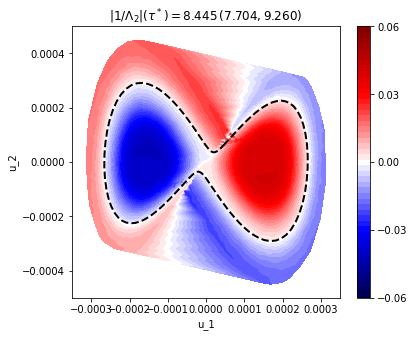

In [25]:
plt.figure(figsize=(6,5))
plt.title(r'$|1/\Lambda_2|(\tau^*) = {:.3f}\,({:.3f},{:.3f})$'.format(tscale_kd[0],tscale_kd[1],tscale_kd[2]))
plt.tricontourf(centers_phspace[:,0],centers_phspace[:,1],phi2,levels=np.linspace(-0.06,0.06,50),cmap='seismic',vmin=-0.06,vmax=0.06)#,cmap='seismic')
plt.plot(phspace[t0:tf+2,0],phspace[t0:tf+2,1],c='k',lw=2,ls='--')
plt.colorbar(ticks=np.linspace(-0.06,0.06,5))
plt.xlim(-3.5e-4,3.5e-4)
plt.ylim(-5e-4,5e-4)
plt.xlabel('u_1')
plt.ylabel('u_2')
# plt.savefig('Koopman_eigfun_Lorenz_phspace.pdf')
plt.show()

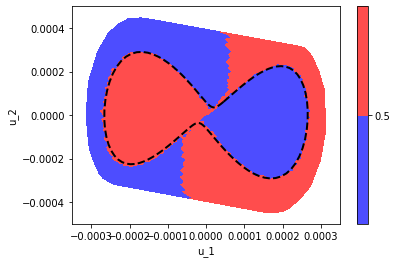

In [26]:
plt.tricontourf(centers_phspace[:,0],centers_phspace[:,1],kmeans_labels,levels=[-.2,0.5,1.2],cmap='seismic',vmin=-.5,vmax=1.5)#,levels=np.linspace(-0.07,0.07,50),cmap='seismic')#,cmap='seismic')
plt.plot(phspace[t0:tf+2,0],phspace[t0:tf+2,1],c='k',lw=2,ls='--')
plt.colorbar(ticks=[0.5])
plt.xlim(-3.5e-4,3.5e-4)
plt.ylim(-5e-4,5e-4)
plt.xlabel('u_1')
plt.ylabel('u_2')
# plt.savefig('labels_Lorenz_phspace.pdf')
plt.show()

# Time scales

In [27]:
n_modes=10
colors_modes = plt.cm.Blues_r(np.linspace(0,.9,n_modes))

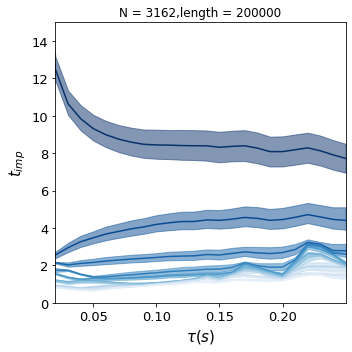

In [28]:
plt.figure(figsize=(5,5))

plt.title('N = {},length = {}'.format(n_clusters,length))

dmax = 25
for mode in range(n_modes):
    mean = np.mean(ts_traj_delay[:,:,mode],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,mode],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,mode],97.5,axis=0)
    plt.plot(delay_range[:dmax]*dt,mean[:dmax],c=colors_modes[mode])
    plt.fill_between(delay_range[:dmax]*dt,cil[:dmax],ciu[:dmax],alpha=.5,color=colors_modes[mode])
plt.xlim(2*dt,dmax*dt)
plt.ylim(0,15)
plt.ylabel('$t_{imp}$',fontsize=15,rotation=90)
plt.xlabel(r'$\tau (s)$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
# plt.savefig('tscales_Lorenz.pdf')

plt.show()

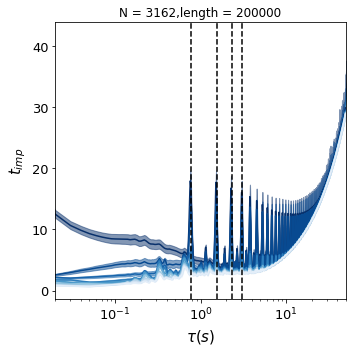

In [29]:
plt.figure(figsize=(5,5))

plt.title('N = {},length = {}'.format(n_clusters,length))


for mode in range(n_modes):
    mean = np.mean(ts_traj_delay[:,:,mode],axis=0)
    cil = np.percentile(ts_traj_delay[:,:,mode],2.5,axis=0)
    ciu = np.percentile(ts_traj_delay[:,:,mode],97.5,axis=0)
    plt.plot(delay_range*dt,mean[:],c=colors_modes[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color=colors_modes[mode])
plt.xlim(2*dt,50)
# plt.ylim(0,15)
plt.xscale('log')
plt.ylabel('$t_{imp}$',fontsize=15,rotation=90)
plt.xlabel(r'$\tau (s)$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(T_UPO/2,ls='--',c='k')
plt.axvline(T_UPO,ls='--',c='k')
plt.axvline(1.5*T_UPO,ls='--',c='k')
plt.axvline(2*T_UPO,ls='--',c='k')
# plt.axvline(3*T_UPO,ls='--',c='k')
# plt.savefig('tscales_Lorenz.pdf')
plt.tight_layout()

plt.show()

In [30]:
n_modes = ts_traj_delay.shape[2]

eigvals_traj_delay = np.copy(ts_traj_delay)
for traj_idx in range(ts_traj_delay.shape[0]):
    eigvals_traj_delay[traj_idx,:,:] = np.exp(-(delay_range*dt)/ts_traj_delay[traj_idx,:,:].T).T
    
part_ratio_traj = np.zeros(eigvals_traj_delay.shape[:2])
for traj_idx in range(ts_traj_delay.shape[0]):
    part_ratio_traj[traj_idx] = (np.sum(eigvals_traj_delay[traj_idx],axis=1)**2/np.sum(eigvals_traj_delay[traj_idx]**2,axis=1))/n_modes


In [31]:
random_labels = np.random.choice(labels_traj,length,replace=False)
P_random = op_calc.transition_matrix(random_labels,1)
R_random = op_calc.get_reversible_transition_matrix(P_random)
eigvals_random,eigvecs = op_calc.sorted_spectrum(R_random,k=R_random.shape[0]-2)

In [32]:
n_modes=10
colors_modes = plt.cm.Blues_r(np.linspace(0,.9,n_modes))

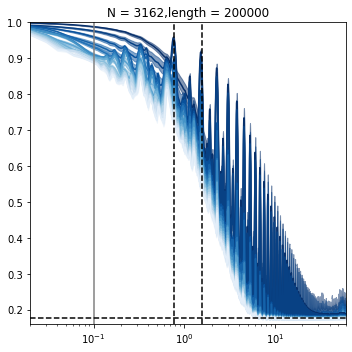

In [33]:
n_modes=15
plt.figure(figsize=(5,5))
colors_modes = plt.cm.Blues_r(np.linspace(0,.9,n_modes))
plt.title('N = {},length = {}'.format(n_clusters,length))
for mode in range(n_modes):
#     mean,cil,ciu=stats.bootstrap(eigvals_traj_delay[:,:,mode],median=False,n_times=1000)
    mean = np.mean(eigvals_traj_delay[:,:,mode],axis=0)
    cil = np.percentile(eigvals_traj_delay[:,:,mode],2.5,axis=0)
    ciu = np.percentile(eigvals_traj_delay[:,:,mode],97.5,axis=0)
    plt.plot(delay_range*dt,mean,c=colors_modes[mode])
    plt.fill_between(delay_range*dt,cil,ciu,alpha=.5,color = colors_modes[mode])
plt.xscale('log')
plt.xlim(2*dt,60)
plt.ylim(0.16,1)
plt.axvline(T_UPO/2,ls='--',c='k')
plt.axvline(T_UPO,ls='--',c='k')
plt.axvline(0.1,c='gray')
plt.tight_layout()
plt.axhline(eigvals_random[1:].max().real,ls='--',c='k')
# plt.savefig('eigvals_Lorenz_noise_level.pdf')
plt.show()

In [34]:
# # mean,cil,ciu = stats.bootstrap(part_ratio_traj,n_times=1000)
# mean = np.mean(part_ratio_traj,axis=0)
# cil = np.percentile(part_ratio_traj,2.5,axis=0)
# ciu = np.percentile(part_ratio_traj,97.5,axis=0)
# plt.plot(delay_range*dt,mean)
# plt.fill_between(delay_range*dt,cil,ciu,alpha=.5)
# plt.xlabel('delay (s)',fontsize=14)
# plt.ylabel('participation ratio',fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# plt.xlim(delay_range[0]*dt,delay_range[-1]*dt)
# plt.ylim(.85,1)
# plt.xscale('log')
# plt.axvline(T_UPO/2,ls='--',c='k')
# plt.axvline(T_UPO,ls='--',c='k')
# plt.axvline(1.5*T_UPO,ls='--',c='k')
# plt.axvline(2*T_UPO,ls='--',c='k')
# plt.axvline(3*T_UPO,ls='--',c='k')

# # plt.savefig('part_ratio_Lorenz.pdf')
# plt.show()